In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class QuantumBitSimulator:
    """
    Single qubit simulator based on the quantum generalization of probability theory
    for symbolic sequences with homotopic equivalence.
    """

    def __init__(self):
        """
        Initialization of the qubit simulator.
        Defines basis states and operators.
        """
        # Define the alphabet with opposite elements
        self.alphabet = ['0', '1', "0'", "1'"]
        self.opposite_pairs = {'0': "0'", '1': "1'", "0'": "0", "1'": "1"}

        # Define basis states |0⟩ and |1⟩
        self.state_0 = np.array([1.0, 0.0], dtype=complex)
        self.state_1 = np.array([0.0, 1.0], dtype=complex)

        # Current state of the qubit (default is |0⟩)
        self.state = self.state_0.copy()

        # Standard quantum gates
        # Pauli-X (NOT gate)
        self.X = np.array([[0, 1], [1, 0]], dtype=complex)

        # Pauli-Y
        self.Y = np.array([[0, -1j], [1j, 0]], dtype=complex)

        # Pauli-Z
        self.Z = np.array([[1, 0], [0, -1]], dtype=complex)

        # Hadamar
        self.H = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)

        # Pahse gate
        self.S = np.array([[1, 0], [0, 1j]], dtype=complex)

        # π/8 gate
        self.T = np.array([[1, 0], [0, np.exp(1j*np.pi/4)]], dtype=complex)

        # State history to track evolution
        self.state_history = [self.state.copy()]

        # History of symbolic representations
        self.symbolic_history = [self.state_to_symbolic(self.state)]

    def state_to_symbolic(self, state):
        """
        Converts a qubit quantum state into a symbolic representation.

        Args:
            state: Qubit state vector [α, β]

        Returns:
            String representing the symbolic state
        """
        # Round small values to zero for readability
        alpha = state[0] if abs(state[0]) > 1e-10 else 0
        beta = state[1] if abs(state[1]) > 1e-10 else 0

        if np.isclose(alpha, 1) and np.isclose(beta, 0):
            return "0"  # State |0⟩
        elif np.isclose(alpha, 0) and np.isclose(beta, 1):
            return "1"  # State |1⟩
        else:
            # General state α|0⟩ + β|1⟩
            alpha_str = f"{alpha:.4f}".rstrip('0').rstrip('.') if alpha else "0"
            beta_str = f"{beta:.4f}".rstrip('0').rstrip('.') if beta else "0"

            symbolic = ""
            if alpha:
                symbolic += f"{alpha_str}|0⟩"
            if beta:
                if symbolic:
                    symbolic += " + "
                symbolic += f"{beta_str}|1⟩"

            return symbolic

    def apply_gate(self, gate, label=None):
        """
        Applies a quantum gate to the current qubit state.

        Args:
            gate: 2x2 unitary matrix representing the quantum gate
            label: String label for the gate (for output)

        Returns:
            The new qubit state after applying the gate
        """
        # Apply the gate to the current state
        self.state = np.dot(gate, self.state)

        # Normalize the state (for numerical stability)
        self.state /= np.linalg.norm(self.state)

        # Save the state in history
        self.state_history.append(self.state.copy())

        # Save the symbolic representation
        self.symbolic_history.append(self.state_to_symbolic(self.state))

        # Output information about the applied gate
        if label:
            print(f"Applied gate {label}: {self.state_to_symbolic(self.state)}")

        return self.state

    def measure(self):
        """
        Performs a measurement of the qubit in the standard basis.

        Returns:
            The measurement result: 0 or 1
        """
        # Calculate probabilities
        p0 = np.abs(self.state[0])**2
        p1 = np.abs(self.state[1])**2

        # Normalize probabilities (for numerical stability)
        total_prob = p0 + p1
        p0 /= total_prob
        p1 /= total_prob

        # Perform the measurement
        result = np.random.choice([0, 1], p=[p0, p1])

        # Collapse the state
        if result == 0:
            self.state = self.state_0.copy()
        else:
            self.state = self.state_1.copy()

        # Update the history
        self.state_history.append(self.state.copy())
        self.symbolic_history.append(self.state_to_symbolic(self.state))

        print(f"Measurement result: {result}, state: {self.state_to_symbolic(self.state)}")

        return result

    def get_bloch_vector(self):
        """
        Calculates the coordinates on the Bloch sphere for the current qubit state.

        Returns:
            Coordinates (x, y, z) on the Bloch sphere
        """
        # Get the values of alpha and beta
        alpha = self.state[0]
        beta = self.state[1]

        # Calculate the Bloch coordinates
        x = 2 * np.real(alpha * np.conj(beta))
        y = 2 * np.imag(alpha * np.conj(beta))
        z = np.abs(alpha)**2 - np.abs(beta)**2

        return np.array([x, y, z])

    def visualize_bloch_sphere(self, history=False):
        """
        Visualizes the current state of the qubit on the Bloch sphere.

        Args:
            history: If True, displays the entire state history
        """
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Draw the Bloch sphere
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))

        # Draw a transparent sphere
        ax.plot_surface(x, y, z, color='lightgray', alpha=0.2)

       # Draw coordinate axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, label='X')
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, label='Y')
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', arrow_length_ratio=0.1, label='Z')

         # Mark standard basis states
        ax.scatter(0, 0, 1, color='b', s=100, label='|0⟩')
        ax.scatter(0, 0, -1, color='r', s=100, label='|1⟩')

        if history:
            # Display the entire state history
            bloch_vectors = [self.get_bloch_vector_from_state(s) for s in self.state_history]
            xs, ys, zs = zip(*bloch_vectors)

            # Draw the trajectory
            ax.plot(xs, ys, zs, 'k-', alpha=0.5)

            # Display all history points
            ax.scatter(xs, ys, zs, color='purple', s=30, alpha=0.5)

            # Display the current state
            current_bloch = self.get_bloch_vector()
            ax.scatter([current_bloch[0]], [current_bloch[1]], [current_bloch[2]],
                      color='orange', s=100, label='Current')
        else:
            # Display only the current state
            bloch = self.get_bloch_vector()
            ax.scatter([bloch[0]], [bloch[1]], [bloch[2]],
                      color='orange', s=150, label='Current state')

            # Draw a line from the center to the state point
            ax.plot([0, bloch[0]], [0, bloch[1]], [0, bloch[2]], 'k-')

        # Graph settings
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])
        ax.set_zlim([-1.2, 1.2])
        ax.set_title('Qubit State Representation on the Bloch Sphere')
        ax.legend()

        plt.tight_layout()
        plt.show()

    def get_bloch_vector_from_state(self, state):
        """
        Calculates the coordinates on the Bloch sphere for the given qubit state.

        Args:
            state: Qubit state vector

        Returns:
            Coordinates (x, y, z) on the Bloch sphere
        """
        # Get the values of alpha and beta
        alpha = state[0]
        beta = state[1]

        # Calculate the Bloch coordinates
        x = 2 * np.real(alpha * np.conj(beta))
        y = 2 * np.imag(alpha * np.conj(beta))
        z = np.abs(alpha)**2 - np.abs(beta)**2

        return np.array([x, y, z])

    def homotopy_reduction(self, symbolic_sequence):
        """
        Performs homotopic reduction of a symbolic sequence,
        removing pairs of opposite elements.

        Args:
            symbolic_sequence: Symbolic sequence

        Returns:
            Homotopically reduced sequence
        """
        # Parse the symbolic sequence
        tokens = []
        i = 0
        while i < len(symbolic_sequence):
            if symbolic_sequence[i] in self.alphabet:
                tokens.append(symbolic_sequence[i])
                i += 1
            else:
                # Skip other symbols (spaces, etc.)
                i += 1

        # Perform homotopic reduction
        reduced = []
        for token in tokens:
            if reduced and token == self.opposite_pairs[reduced[-1]]:
                # Remove a pair of opposite elements
                reduced.pop()
            else:
                reduced.append(token)

        return ''.join(reduced)

    def symbolic_to_state(self, symbolic_sequence):
        """
        Converts a symbolic representation into a qubit quantum state.

        Args:
            symbolic_sequence: Symbolic representation of the state

        Returns:
            Qubit state vector [α, β]
        """
        # Reduce the sequence
        reduced = self.homotopy_reduction(symbolic_sequence)

        if reduced == "0":
            return self.state_0.copy()
        elif reduced == "1":
            return self.state_1.copy()
        elif "0" in reduced and "1" in reduced:
            # Parse an expression of the form α|0⟩ + β|1⟩
            alpha = 0.0
            beta = 0.0

            # Simple parser for demonstration purposes
            parts = reduced.split("+")
            for part in parts:
                part = part.strip()
                if "|0⟩" in part:
                    try:
                        alpha_str = part.split("|0⟩")[0].strip()
                        alpha = complex(alpha_str) if alpha_str else 1.0
                    except:
                        alpha = 1.0
                elif "|1⟩" in part:
                    try:
                        beta_str = part.split("|1⟩")[0].strip()
                        beta = complex(beta_str) if beta_str else 1.0
                    except:
                        beta = 1.0

            # Create and normalize the state
            state = np.array([alpha, beta], dtype=complex)
            return state / np.linalg.norm(state)
        else:
            # Return |0⟩ by default
            return self.state_0.copy()

    def symbolic_gate(self, symbolic_operator, input_state=None):
        """
        Applies a symbolic operator to a symbolic state.

        Args:
            symbolic_operator: Symbolic representation of the operator
            input_state: Symbolic representation of the input state (default is current)

        Returns:
            Symbolic representation of the resulting state
        """
        # Define the input state
        if input_state is None:
            state = self.state
        else:
            state = self.symbolic_to_state(input_state)

        # Recognize the symbolic operator
        if symbolic_operator.upper() == "X" or symbolic_operator.upper() == "NOT":
            result_state = np.dot(self.X, state)
        elif symbolic_operator.upper() == "Y":
            result_state = np.dot(self.Y, state)
        elif symbolic_operator.upper() == "Z":
            result_state = np.dot(self.Z, state)
        elif symbolic_operator.upper() == "H":
            result_state = np.dot(self.H, state)
        elif symbolic_operator.upper() == "S":
            result_state = np.dot(self.S, state)
        elif symbolic_operator.upper() == "T":
            result_state = np.dot(self.T, state)
        else:
            # Unknown operator, return the original state
            result_state = state

        # Normalize the result
        result_state /= np.linalg.norm(result_state)

        # If applying to the current state, update it
        if input_state is None:
            self.state = result_state
            self.state_history.append(self.state.copy())
            self.symbolic_history.append(self.state_to_symbolic(self.state))

        return self.state_to_symbolic(result_state)

    def quantum_homotopy_distance(self, state1, state2):
        """
        Calculates the quantum homotopic distance between two states.

        Args:
            state1, state2: Qubit state vectors

        Returns:
            The value of the quantum homotopic distance
        """
        # Calculate the angular distance on the Bloch sphere
        bloch1 = self.get_bloch_vector_from_state(state1)
        bloch2 = self.get_bloch_vector_from_state(state2)

        # Normalize the vectors
        bloch1 = bloch1 / np.linalg.norm(bloch1) if np.linalg.norm(bloch1) > 0 else bloch1
        bloch2 = bloch2 / np.linalg.norm(bloch2) if np.linalg.norm(bloch2) > 0 else bloch2

        # Angular distance (in radians)
        dot_product = np.clip(np.dot(bloch1, bloch2), -1.0, 1.0)
        distance = np.arccos(dot_product)

        return distance

    def run_quantum_circuit(self, circuit_description):
        """
        Executes a quantum circuit described as a sequence of gates.

        Args:
            circuit_description: List of strings describing the gates to apply

        Returns:
            Symbolic representation of the final state
        """
        # Reset the state to |0⟩
        self.state = self.state_0.copy()
        self.state_history = [self.state.copy()]
        self.symbolic_history = [self.state_to_symbolic(self.state)]

        print(f"Initial state: {self.state_to_symbolic(self.state)}")

        # Apply the gates
        for gate_desc in circuit_description:
            gate_desc = gate_desc.strip().upper()

            if gate_desc == "X" or gate_desc == "NOT":
                self.apply_gate(self.X, "X")
            elif gate_desc == "Y":
                self.apply_gate(self.Y, "Y")
            elif gate_desc == "Z":
                self.apply_gate(self.Z, "Z")
            elif gate_desc == "H":
                self.apply_gate(self.H, "H")
            elif gate_desc == "S":
                self.apply_gate(self.S, "S")
            elif gate_desc == "T":
                self.apply_gate(self.T, "T")
            elif gate_desc == "MEASURE":
                self.measure()
            else:
                print(f"Unknown gate: {gate_desc}, skipping")

        print(f"Final state: {self.state_to_symbolic(self.state)}")

        return self.state_to_symbolic(self.state)

    def create_bell_state(self):
        """
        Simulates the creation of the Bell state |Φ+⟩ = (|00⟩ + |11⟩)/√2.
        Note: This method is symbolic because we are only simulating one qubit.

        Returns:
            Symbolic representation of the Bell state
        """
        print("Symbolic creation of the Bell state |Φ+⟩ = (|00⟩ + |11⟩)/√2")
        print("Note: This is a symbolic operation as we are only simulating one qubit")

        return "(|00⟩ + |11⟩)/√2"

def run_single_qubit_demos():
    """
    Demonstrates the operation of the single qubit simulator.
    """
    # Create an instance of the simulator
    simulator = QuantumBitSimulator()

    print("=== Demonstration 1: Basic Quantum Gates ===")
    # Run a simple quantum circuit
    circuit = ["H", "T", "H", "X", "Z", "MEASURE"]
    simulator.run_quantum_circuit(circuit)

    # Visualize the Bloch sphere with state history
    simulator.visualize_bloch_sphere(history=True)

    print("\n=== Demonstration 2: Superposition and Interference ===")
    # Create an equal superposition
    circuit2 = ["H", "H", "H", "MEASURE"]
    simulator.run_quantum_circuit(circuit2)

    # Visualize the final state
    simulator.visualize_bloch_sphere()

    print("\n=== Demonstration 3: Homotopic Reduction ===")
    # Create a symbolic sequence with opposite elements
    seq = "01'10'"
    reduced = simulator.homotopy_reduction(seq)
    print(f"Original sequence: {seq}")
    print(f"After homotopic reduction: {reduced}")

    print("\n=== Demonstration 4: Quantum Homotopic Distance ===")
    # Create two states and calculate the distance between them
    state1 = simulator.symbolic_to_state("0")  # |0⟩
    state2 = simulator.symbolic_to_state("1")  # |1⟩
    state3 = simulator.symbolic_to_state("0.707|0⟩ + 0.707|1⟩")  # |+⟩

    dist1 = simulator.quantum_homotopy_distance(state1, state2)
    dist2 = simulator.quantum_homotopy_distance(state1, state3)

    print(f"Distance between |0⟩ and |1⟩: {dist1:.4f} radians (π radians = 180°)")
    print(f"Distance between |0⟩ and |+⟩: {dist2:.4f} radians (π/2 radians = 90°)")

    print("\n=== Demonstration 5: Deutsch's Algorithm ===")
    print("Simulation of Deutsch's algorithm for functions f(x)=0 and f(x)=1")

    # Deutsch's algorithm for f(x)=0 (constant function)
    print("\nDeutsch's algorithm for f(x)=0:")
    deutsch_circuit_const = ["H", "Z", "H", "MEASURE"]
    simulator.run_quantum_circuit(deutsch_circuit_const)

    # Deutsch's algorithm for f(x)=x (balanced function)
    print("\nDeutsch's algorithm for f(x)=x:")
    deutsch_circuit_balanced = ["H", "X", "Z", "H", "MEASURE"]
    simulator.run_quantum_circuit(deutsch_circuit_balanced)

def quantum_state_tomography_demo(simulator):
    """
    Demonstrates quantum state tomography.
    Estimates an unknown quantum state by performing multiple measurements in different bases.

    Args:
        simulator: An instance of the QuantumBitSimulator
    """
    print("\n=== Demonstration: Quantum State Tomography ===")

    # Prepare an unknown state (in real tomography, it is unknown)
    unknown_state = np.array([np.cos(np.pi/8), np.sin(np.pi/8)], dtype=complex)
    simulator.state = unknown_state.copy()

    print(f"True state: {simulator.state_to_symbolic(simulator.state)}")

    # Tomography parameters
    num_measurements = 1000

    # Measurement counters in different bases
    basis_z_counts = {0: 0, 1: 0}  # |0⟩, |1⟩
    basis_x_counts = {'+': 0, '-': 0}  # |+⟩, |-⟩
    basis_y_counts = {'+i': 0, '-i': 0}  # |+i⟩, |-i⟩

    # 1. Measurements in the Z-basis (standard basis)
    for _ in range(num_measurements):
        # Restore the state
        simulator.state = unknown_state.copy()

        # Measure
        result = simulator.measure()
        basis_z_counts[result] += 1

    # 2. Measurements in the X-basis (Hadamard)
    for _ in range(num_measurements):
        # Restore the state
        simulator.state = unknown_state.copy()

        # Transform to the X-basis and measure
        simulator.apply_gate(simulator.H)
        result = simulator.measure()
        basis_x_counts['+' if result == 0 else '-'] += 1

    # 3. Measurements in the Y-basis (S†H)
    s_dagger = np.array([[1, 0], [0, -1j]], dtype=complex)
    for _ in range(num_measurements):
        # Restore the state
        simulator.state = unknown_state.copy()

        # Transform to the Y-basis and measure
        simulator.apply_gate(np.dot(s_dagger, simulator.H))
        result = simulator.measure()
        basis_y_counts['+i' if result == 0 else '-i'] += 1

    # Calculate probabilities
    prob_z0 = basis_z_counts[0] / num_measurements
    prob_z1 = basis_z_counts[1] / num_measurements
    prob_x_plus = basis_x_counts['+'] / num_measurements
    prob_x_minus = basis_x_counts['-'] / num_measurements
    prob_y_plus = basis_y_counts['+i'] / num_measurements
    prob_y_minus = basis_y_counts['-i'] / num_measurements

    # Reconstruct the density matrix
    rho = np.zeros((2, 2), dtype=complex)

    # Use the relations:
    # <Z> = p(0) - p(1) = rho[0,0] - rho[1,1]
    # <X> = p(+) - p(-) = rho[0,1] + rho[1,0]
    # <Y> = p(+i) - p(-i) = i(rho[1,0] - rho[0,1])

    z_expectation = prob_z0 - prob_z1
    x_expectation = prob_x_plus - prob_x_minus
    y_expectation = prob_y_plus - prob_y_minus

    # Components of the Bloch vector
    estimated_bloch = np.array([x_expectation, y_expectation, z_expectation])

    # Reconstruct the density matrix
    rho[0, 0] = (1 + z_expectation) / 2
    rho[1, 1] = (1 - z_expectation) / 2
    rho[0, 1] = (x_expectation - 1j * y_expectation) / 2
    rho[1, 0] = (x_expectation + 1j * y_expectation) / 2

    # Reconstruct the amplitudes (for a pure state)
    # For a pure state, we can simply take the square root of the diagonal elements
    estimated_alpha = np.sqrt(rho[0, 0])
    estimated_beta = np.sqrt(rho[1, 1]) * np.exp(1j * np.angle(rho[0, 1])) if rho[0, 1] != 0 else 0

    estimated_state = np.array([estimated_alpha, estimated_beta], dtype=complex)

    print(f"\nMeasurement results:")
    print(f"Z-basis: |0⟩: {prob_z0:.4f}, |1⟩: {prob_z1:.4f}")
    print(f"X-basis: |+⟩: {prob_x_plus:.4f}, |-⟩: {prob_x_minus:.4f}")
    print(f"Y-basis: |+i⟩: {prob_y_plus:.4f}, |-i⟩: {prob_y_minus:.4f}")

    print(f"\nBloch vector estimation: [{estimated_bloch[0]:.4f}, {estimated_bloch[1]:.4f}, {estimated_bloch[2]:.4f}]")
    print(f"State estimation: {simulator.state_to_symbolic(estimated_state)}")

    # Calculate the fidelity between the true and estimated states
    fidelity = np.abs(np.dot(np.conj(unknown_state), estimated_state))**2
    print(f"Fidelity of the estimation: {fidelity:.4f}")

    # Visualize the true and estimated Bloch vectors
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Draw the Bloch sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    # Draw a transparent sphere
    ax.plot_surface(x, y, z, color='lightgray', alpha=0.2)

    # Draw coordinate axes
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, label='X')
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, label='Y')
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', arrow_length_ratio=0.1, label='Z')

    # Mark standard basis states
    ax.scatter(0, 0, 1, color='b', s=100, label='|0⟩')
    ax.scatter(0, 0, -1, color='r', s=100, label='|1⟩')

    # True Bloch vector
    true_bloch = simulator.get_bloch_vector_from_state(unknown_state)
    ax.scatter([true_bloch[0]], [true_bloch[1]], [true_bloch[2]],
              color='green', s=150, label='True state')
    ax.plot([0, true_bloch[0]], [0, true_bloch[1]], [0, true_bloch[2]], 'g-')

    # Estimated Bloch vector
    ax.scatter([estimated_bloch[0]], [estimated_bloch[1]], [estimated_bloch[2]],
              color='orange', s=150, label='Estimated state')
    ax.plot([0, estimated_bloch[0]], [0, estimated_bloch[1]], [0, estimated_bloch[2]], 'orange')

    # Настройка графика
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_zlim([-1.2, 1.2])
    ax.set_title('Comparison of True and Estimated States on the Bloch Sphere')
    ax.legend()

    plt.tight_layout()
    plt.show()

def quantum_fourier_transform_demo(simulator):
    """
    Demonstrates the quantum Fourier transform symbolically.

    Args:
        simulator: An instance of the QuantumBitSimulator
    """
    print("\n=== Demonstration: Quantum Fourier Transform (QFT) ===")
    print("For a single qubit, QFT is equivalent to the Hadamard transform")

    # Prepare the state |0⟩
    simulator.state = simulator.state_0.copy()
    print(f"Initial state: {simulator.state_to_symbolic(simulator.state)}")

    # Apply QFT (for a single qubit, it's just the Hadamard gate)
    simulator.apply_gate(simulator.H, "QFT (H)")

    print(f"After QFT: {simulator.state_to_symbolic(simulator.state)}")

    # Visualize the state on the Bloch sphere
    simulator.visualize_bloch_sphere()

    # Now we demonstrate how a two-qubit QFT would look symbolically
    print("\nSymbolic representation of a two-qubit QFT:")
    print("|00⟩ → (|00⟩ + |01⟩ + |10⟩ + |11⟩)/2")
    print("|01⟩ → (|00⟩ + i|01⟩ - |10⟩ - i|11⟩)/2")
    print("|10⟩ → (|00⟩ - |01⟩ + |10⟩ - |11⟩)/2")
    print("|11⟩ → (|00⟩ - i|01⟩ - |10⟩ + i|11⟩)/2")

def grover_search_demo(simulator):
    """
    Demonstrates the symbolic representation of Grover's search algorithm.

    Args:
        simulator: An instance of the QuantumBitSimulator
    """
    print("\n=== Demonstration: Grover's Search Algorithm (Symbolic) ===")
    print("For a single qubit, this is a trivial case")

    # Prepare the state |0⟩
    simulator.state = simulator.state_0.copy()
    print(f"Initial state: {simulator.state_to_symbolic(simulator.state)}")

    # Step 1: Create an equal superposition using the Hadamard gate
    simulator.apply_gate(simulator.H, "H (step 1)")
    print(f"After creating superposition: {simulator.state_to_symbolic(simulator.state)}")

    # Step 2: Oracle (inverts the amplitude of the target state)
    # Let the target state be |1⟩
    oracle = np.array([[1, 0], [0, -1]], dtype=complex)  # Z-гейт для инвертирования |1⟩
    simulator.apply_gate(oracle, "Oracle (step 2)")
    print(f"After applying the oracle: {simulator.state_to_symbolic(simulator.state)}")

    # Step 3: Diffusion (reflection about the mean)
    # For a single qubit, this is simply -Z after H
    diffusion = np.dot(np.dot(simulator.H, -simulator.Z), simulator.H)
    simulator.apply_gate(diffusion, "Diffusion (step 3)")
    print(f"After diffusion: {simulator.state_to_symbolic(simulator.state)}")

    # Visualize the state on the Bloch sphere
    simulator.visualize_bloch_sphere(history=True)

    # Show the measurement
    result = simulator.measure()
    print(f"Measurement result: {result} (should be 1 for our example)")

    # Символическое представление для двух кубитов
    print("\nSymbolic example for two qubits (searching for |11⟩):")
    print("1. Initial state: |00⟩")
    print("2. After H⊗H: (|00⟩ + |01⟩ + |10⟩ + |11⟩)/2")
    print("3. After the oracle: (|00⟩ + |01⟩ + |10⟩ - |11⟩)/2")
    print("4. After diffusion: (-|00⟩ - |01⟩ - |10⟩ + |11⟩)/2")
    print("5. Measurement will yield |11⟩ with high probability")

def quantum_homotopy_circuit_demo(simulator):
    """
    Demonstrates a quantum circuit with a homotopic interpretation.

    Args:
        simulator: An instance of QuantumBitSimulator
    """
    print("\n=== Demonstration: Quantum Circuit with Homotopic Interpretation ===")

    # Define a sequence of operations as homotopic deformations
    print("Interpretation of quantum gates as homotopic deformations of paths on the Bloch sphere:")
    print("X-gate: Reflection about the equator (π rotation around the X-axis)")
    print("Z-gate: Reflection about the meridian (π rotation around the Z-axis)")
    print("H-gate: π/2 rotation around the Y-axis, followed by a π rotation around the X-axis")

    # Start with the |0⟩ state
    simulator.state = simulator.state_0.copy()
    print(f"\nInitial state: {simulator.state_to_symbolic(simulator.state)}")

    # Create a list to store the state history and their Bloch coordinates
    states = [simulator.state.copy()]
    bloch_coords = [simulator.get_bloch_vector()]

    # Apply a series of gates, interpreting them as homotopic deformations

    # 1. H-gate: Converts |0⟩ to |+⟩
    simulator.apply_gate(simulator.H, "H")
    states.append(simulator.state.copy())
    bloch_coords.append(simulator.get_bloch_vector())

    # 2. S-gate: Phase rotation by π/2, converts |+⟩ to |+i⟩
    simulator.apply_gate(simulator.S, "S")
    states.append(simulator.state.copy())
    bloch_coords.append(simulator.get_bloch_vector())

    # 3. H-gate: Converts |+i⟩ to a new state
    simulator.apply_gate(simulator.H, "H")
    states.append(simulator.state.copy())
    bloch_coords.append(simulator.get_bloch_vector())

    # 4. T-gate: Phase rotation by π/4
    simulator.apply_gate(simulator.T, "T")
    states.append(simulator.state.copy())
    bloch_coords.append(simulator.get_bloch_vector())

    # 5. Z-gate: π rotation around the Z-axis
    simulator.apply_gate(simulator.Z, "Z")
    states.append(simulator.state.copy())
    bloch_coords.append(simulator.get_bloch_vector())

    print(f"\nFinal state: {simulator.state_to_symbolic(simulator.state)}")

    # Calculate the homotopic path length
    path_length = 0
    for i in range(1, len(bloch_coords)):
        # Calculate the distance between sequential points on the Bloch sphere
        vec1 = bloch_coords[i-1]
        vec2 = bloch_coords[i]

        # Normalize vectors for stable calculations
        vec1_norm = vec1 / np.linalg.norm(vec1) if np.linalg.norm(vec1) > 0 else vec1
        vec2_norm = vec2 / np.linalg.norm(vec2) if np.linalg.norm(vec2) > 0 else vec2

        # Angular distance (in radians)
        dot_product = np.clip(np.dot(vec1_norm, vec2_norm), -1.0, 1.0)
        angle = np.arccos(dot_product)

        path_length += angle

    print(f"\nHomotopic path length on the Bloch sphere: {path_length:.4f} radians")

    # Visualize the path on the Bloch sphere
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Draw the Bloch sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    # Draw a transparent sphere
    ax.plot_surface(x, y, z, color='lightgray', alpha=0.2)

    # Draw coordinate axes
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, label='X')
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, label='Y')
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', arrow_length_ratio=0.1, label='Z')

    # Mark standard basis states
    ax.scatter(0, 0, 1, color='b', s=100, label='|0⟩')
    ax.scatter(0, 0, -1, color='r', s=100, label='|1⟩')

    # Extract Bloch vector coordinates
    xs, ys, zs = zip(*bloch_coords)

    # Plot the trajectory
    ax.plot(xs, ys, zs, 'k-', linewidth=2, label='Homotopic Path')

    # Display points with labels
    labels = ['|0⟩', 'H|0⟩', 'SH|0⟩', 'HSH|0⟩', 'THSH|0⟩', 'ZTHSH|0⟩']
    colors = ['blue', 'cyan', 'magenta', 'yellow', 'green', 'red']

    for i, (x, y, z) in enumerate(zip(xs, ys, zs)):
        ax.scatter([x], [y], [z], color=colors[i], s=100)
        ax.text(x*1.1, y*1.1, z*1.1, labels[i], color=colors[i], fontsize=10)

    # Configure the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_zlim([-1.2, 1.2])
    ax.set_title('Homotopic Path of the Quantum State on the Bloch Sphere')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Run the complete demonstration
def run_complete_demo():
    simulator = QuantumBitSimulator()

    # Basic demonstrations
    run_single_qubit_demos()

    # Additional demonstrations
    quantum_state_tomography_demo(simulator)
    quantum_fourier_transform_demo(simulator)
    grover_search_demo(simulator)
    quantum_homotopy_circuit_demo(simulator)

=== Demonstration 1: Basic Quantum Gates ===
Initial state: 0
Applied gate H: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
Applied gate T: 0.7071+0.0000j|0⟩ + 0.5000+0.5000j|1⟩
Applied gate H: 0.8536+0.3536j|0⟩ + 0.1464-0.3536j|1⟩
Applied gate X: 0.1464-0.3536j|0⟩ + 0.8536+0.3536j|1⟩
Applied gate Z: 0.1464-0.3536j|0⟩ + -0.8536-0.3536j|1⟩
Measurement result: 1, state: 1
Final state: 1


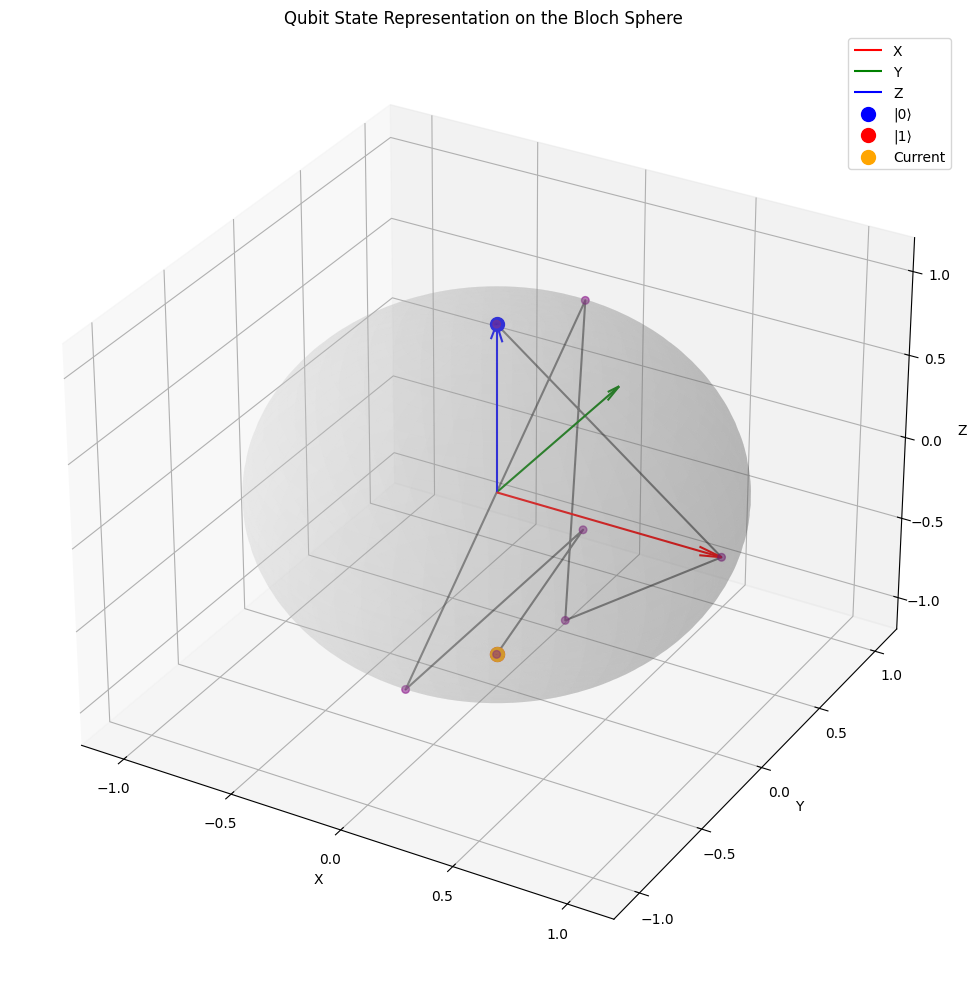


=== Demonstration 2: Superposition and Interference ===
Initial state: 0
Applied gate H: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
Applied gate H: 0
Applied gate H: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
Measurement result: 0, state: 0
Final state: 0


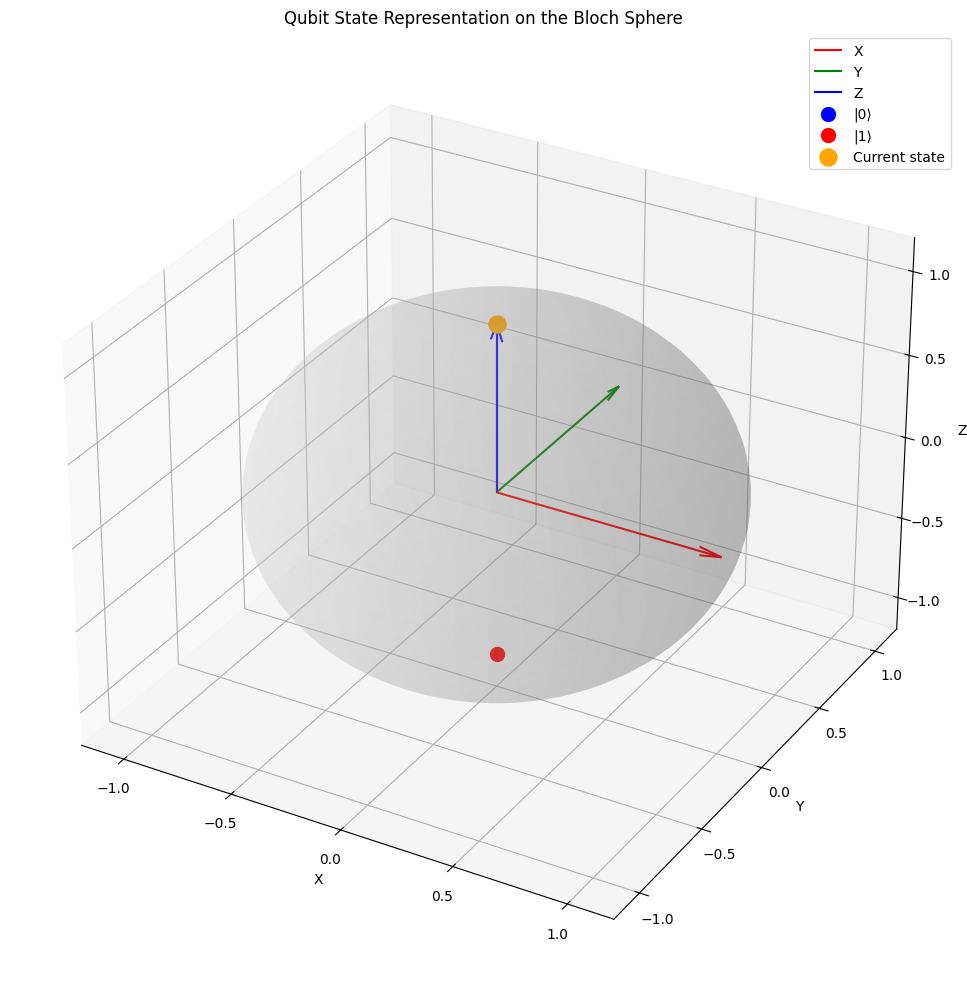


=== Demonstration 3: Homotopic Reduction ===
Original sequence: 01'10'
After homotopic reduction: 0110

=== Demonstration 4: Quantum Homotopic Distance ===
Distance between |0⟩ and |1⟩: 3.1416 radians (π radians = 180°)
Distance between |0⟩ and |+⟩: nan radians (π/2 radians = 90°)

=== Demonstration 5: Deutsch's Algorithm ===
Simulation of Deutsch's algorithm for functions f(x)=0 and f(x)=1

Deutsch's algorithm for f(x)=0:
Initial state: 0
Applied gate H: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
Applied gate Z: 0.7071+0.0000j|0⟩ + -0.7071+0.0000j|1⟩
Applied gate H: 1
Measurement result: 1, state: 1
Final state: 1

Deutsch's algorithm for f(x)=x:
Initial state: 0
Applied gate H: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
Applied gate X: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
Applied gate Z: 0.7071+0.0000j|0⟩ + -0.7071+0.0000j|1⟩
Applied gate H: 1
Measurement result: 1, state: 1
Final state: 1

=== Demonstration: Quantum State Tomography ===
True state: 0.9239+0.0000j|0⟩ + 0.3827+0.0000j|1⟩
Meas

/tmp/ipykernel_85618/3289878858.py:322: RuntimeWarning: invalid value encountered in divide
  return state / np.linalg.norm(state)


Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 1, state: 1
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 1, state: 1
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 1, state: 1
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 1, state: 1
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurement result: 0, state: 0
Measurem

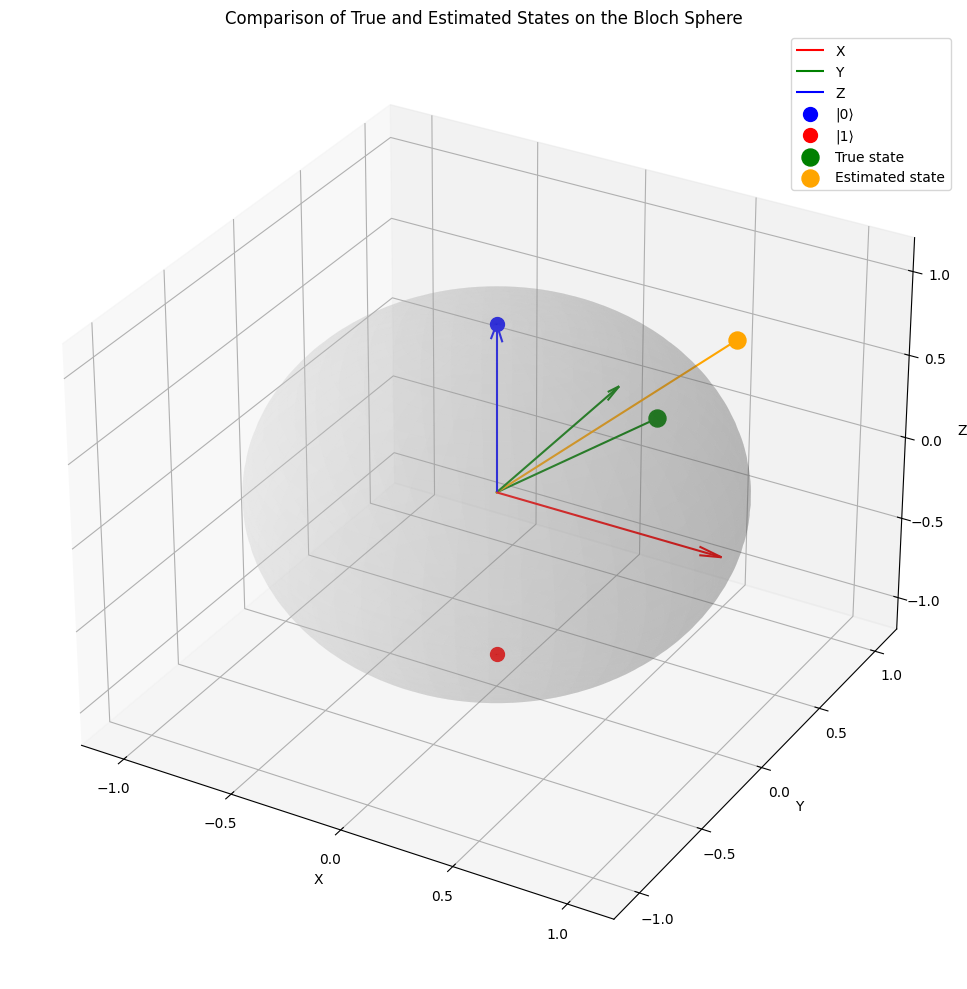


=== Demonstration: Quantum Fourier Transform (QFT) ===
For a single qubit, QFT is equivalent to the Hadamard transform
Initial state: 0
Applied gate QFT (H): 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
After QFT: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩


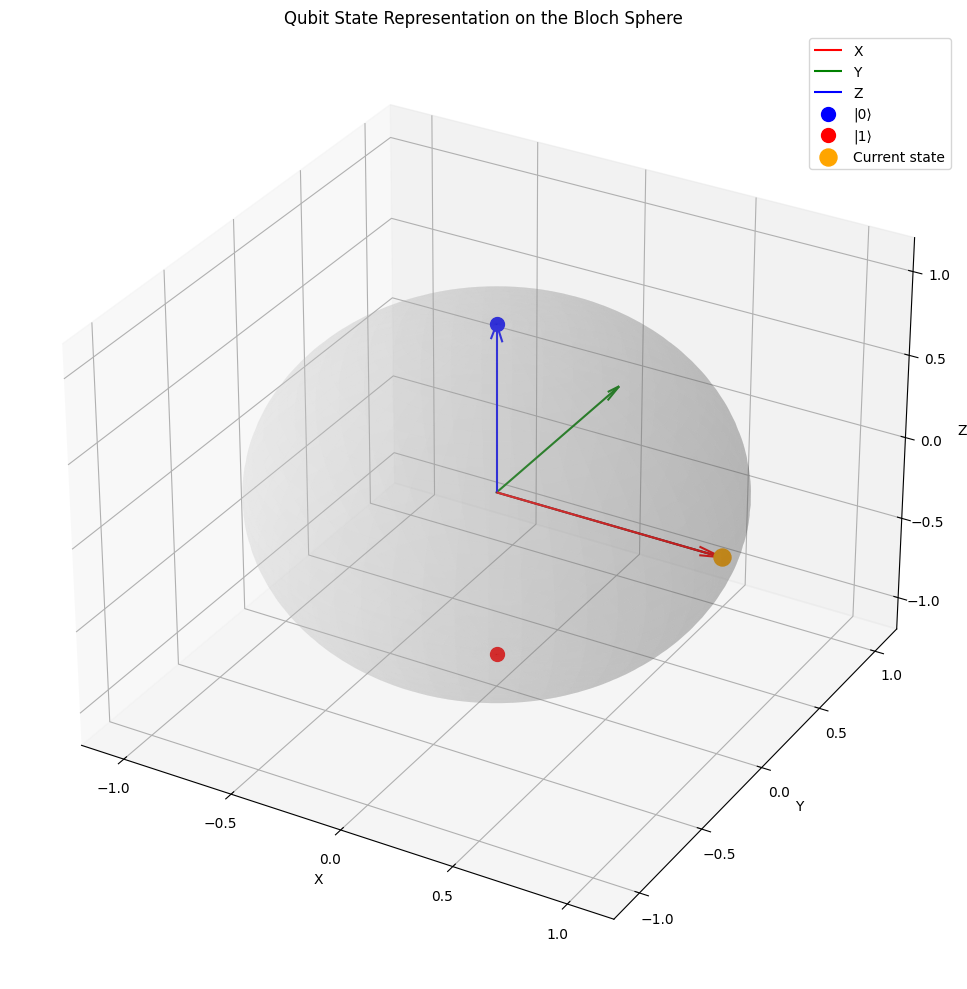


Symbolic representation of a two-qubit QFT:
|00⟩ → (|00⟩ + |01⟩ + |10⟩ + |11⟩)/2
|01⟩ → (|00⟩ + i|01⟩ - |10⟩ - i|11⟩)/2
|10⟩ → (|00⟩ - |01⟩ + |10⟩ - |11⟩)/2
|11⟩ → (|00⟩ - i|01⟩ - |10⟩ + i|11⟩)/2

=== Demonstration: Grover's Search Algorithm (Symbolic) ===
For a single qubit, this is a trivial case
Initial state: 0
Applied gate H (step 1): 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
After creating superposition: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
Applied gate Oracle (step 2): 0.7071+0.0000j|0⟩ + -0.7071+0.0000j|1⟩
After applying the oracle: 0.7071+0.0000j|0⟩ + -0.7071+0.0000j|1⟩
Applied gate Diffusion (step 3): 0.7071+0.0000j|0⟩ + -0.7071+0.0000j|1⟩
After diffusion: 0.7071+0.0000j|0⟩ + -0.7071+0.0000j|1⟩


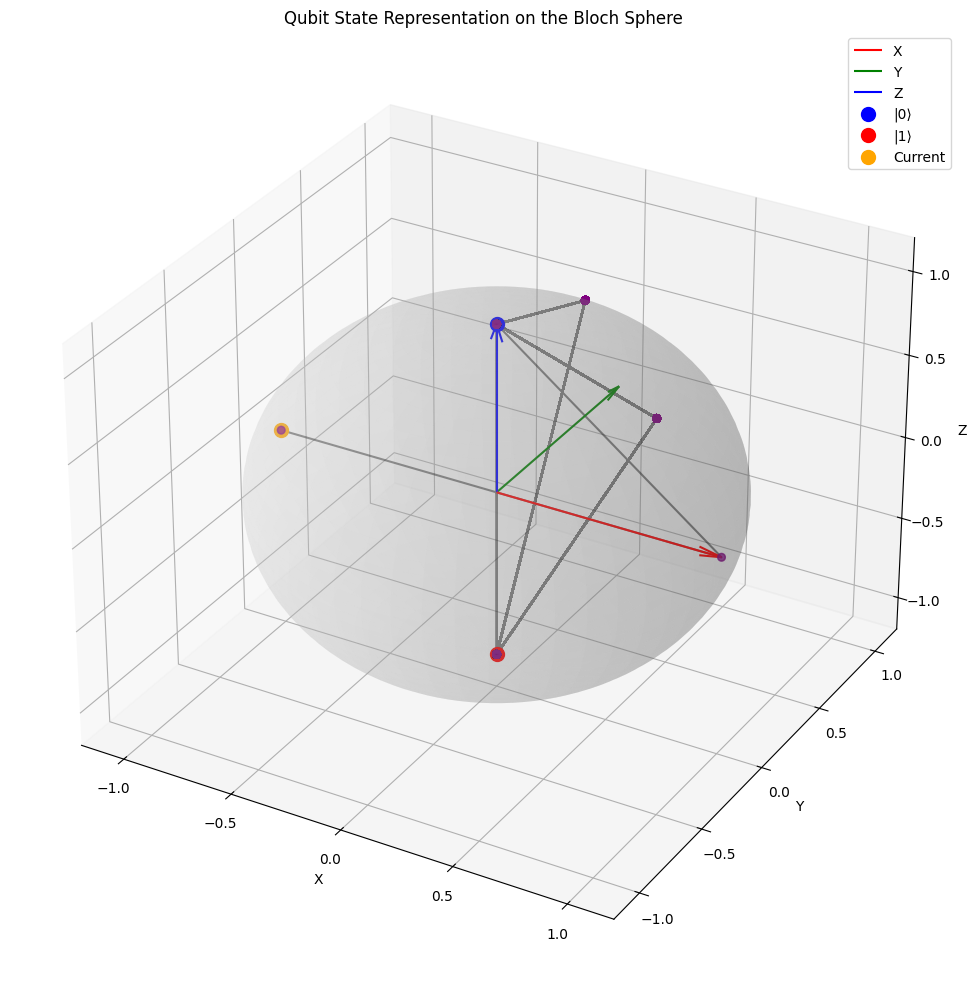

Measurement result: 0, state: 0
Measurement result: 0 (should be 1 for our example)

Symbolic example for two qubits (searching for |11⟩):
1. Initial state: |00⟩
2. After H⊗H: (|00⟩ + |01⟩ + |10⟩ + |11⟩)/2
3. After the oracle: (|00⟩ + |01⟩ + |10⟩ - |11⟩)/2
4. After diffusion: (-|00⟩ - |01⟩ - |10⟩ + |11⟩)/2
5. Measurement will yield |11⟩ with high probability

=== Demonstration: Quantum Circuit with Homotopic Interpretation ===
Interpretation of quantum gates as homotopic deformations of paths on the Bloch sphere:
X-gate: Reflection about the equator (π rotation around the X-axis)
Z-gate: Reflection about the meridian (π rotation around the Z-axis)
H-gate: π/2 rotation around the Y-axis, followed by a π rotation around the X-axis

Initial state: 0
Applied gate H: 0.7071+0.0000j|0⟩ + 0.7071+0.0000j|1⟩
Applied gate S: 0.7071+0.0000j|0⟩ + 0.0000+0.7071j|1⟩
Applied gate H: 0.5000+0.5000j|0⟩ + 0.5000-0.5000j|1⟩
Applied gate T: 0.5000+0.5000j|0⟩ + 0.7071-0.0000j|1⟩
Applied gate Z: 0.5000+0.50

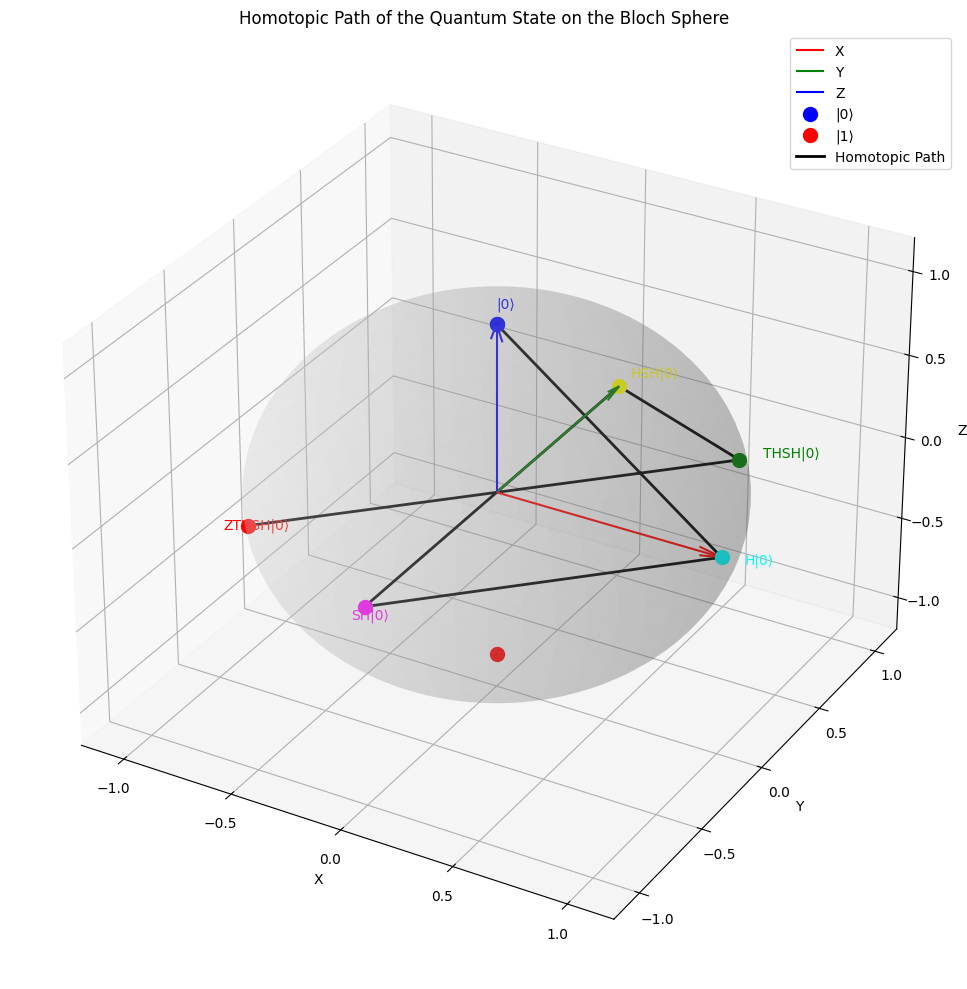

In [3]:
# Run the complete demonstration
run_complete_demo()